#Task 4: Noisy Simulation and Error Mitigation

## 📝 Introduction
While ideal, noiseless simulators are crucial for designing quantum algorithms, real quantum computers are subject to environmental noise. This noise, caused by factors like imperfect gate operations and decoherence, introduces errors that can corrupt the results of a computation.

This notebook addresses Tasks 4 and 5 of the project. We will investigate the impact of realistic hardware noise on our Quantum Galton Box simulation. We will first establish a "noisy baseline" to see how much the noise degrades accuracy. Then, we will implement a basic but powerful error mitigation technique—circuit optimization via transpilation—to improve the result. The goal is to demonstrate that we can actively combat the effects of noise to achieve a more accurate and reliable simulation.

In [1]:
!pip install qiskit==0.45.1 qiskit-aer==0.13.1

In [53]:
# 1. IMPORT LIBRARIES
import numpy as np
import matplotlib.pyplot as plt
import time
from qiskit import QuantumCircuit, transpile
from qiskit.providers.fake_provider import FakeVigo
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from scipy.stats import binom, entropy

### Simulating a Realistic Quantum Backend
To simulate a real quantum device, we use a NoiseModel derived from a FakeBackend. In this case, we use FakeVigo, which is a software model that contains all the specific error characteristics of the retired 5-qubit IBM Quantum system named "Vigo". This includes:

Gate Errors: The probability that a CNOT, Hadamard, or other gate will perform an incorrect operation.

Decoherence: The tendency for qubits to lose their quantum information over time.

Coupling Map: The physical connectivity constraints of the device (i.e., which qubits can directly interact).

By configuring our AerSimulator with this model, we ensure our simulation closely approximates the behavior of a real-world quantum computer.

In [240]:
# 2. SETUP THE NOISY SIMULATOR
# Create a realistic noise model from the properties of a fake backend (FakeVigo)
backend = FakeVigo()
noise_model = NoiseModel.from_backend(backend)
coupling_map = backend.configuration().coupling_map
basis_gates = noise_model.basis_gates

In [241]:
# Create a high-performance simulator configured with the backend's noise properties
noisy_sim = AerSimulator(
    noise_model=noise_model,
    coupling_map=coupling_map,
    basis_gates=basis_gates)

In [242]:
# 3. DEFINE HELPER FUNCTIONS
def build_galton_box_circuit(n_layers):
    """Creates the quantum circuit for the binomial walk."""
    position_qubits = n_layers
    ancilla_qubit = n_layers
    qc = QuantumCircuit(position_qubits + 1, position_qubits)
    # For each layer, perform a quantum 'coin flip' and update the position
    for i in range(n_layers):
        qc.h(ancilla_qubit)
        qc.cx(ancilla_qubit, i)
        qc.reset(ancilla_qubit)
    qc.measure(range(position_qubits), range(position_qubits))
    return qc

In [243]:
def process_counts(counts_dict, n_layers):
    """Processes raw bitstring counts into a final position probability distribution."""
    positions = {i: 0 for i in range(n_layers + 1)}
    total_shots = sum(counts_dict.values())
    # The final position is the number of '1's in the bitstring (Hamming weight)
    for bitstring, count in counts_dict.items():
        pos = bitstring.count('1')
        if pos in positions:
            positions[pos] += count
    outcomes = np.arange(n_layers + 1)
    probs = np.array([positions.get(i, 0) / total_shots for i in outcomes])
    return outcomes, probs

In [244]:
# 4. SETUP AND BUILD THE CIRCUIT
n_layers = 8
shots = 8192
binomial_circuit = build_galton_box_circuit(n_layers)

In [245]:
# 5. RUN SIMULATIONS (BASELINE AND OPTIMIZED)

### Noisy Baseline Simulation
Our first step is to run our standard binomial walk circuit on the noisy simulator without any modifications. This gives us a noisy baseline result. We expect the final distribution to be distorted compared to the ideal case, resulting in a higher KL Divergence. This score quantifies the impact of the hardware noise on our algorithm's accuracy.

In [246]:
# --- Run the baseline noisy simulation ---
print("Running baseline noisy simulation...")
start_time_noisy = time.time()
result_noisy = noisy_sim.run(binomial_circuit, shots=shots).result()
counts_noisy = result_noisy.get_counts()
end_time_noisy = time.time()
execution_time_noisy = end_time_noisy - start_time_noisy
print(f"Baseline simulation executed in: {execution_time_noisy:.2f} seconds")

Running baseline noisy simulation...
Baseline simulation executed in: 0.33 seconds


### Error Mitigation with Circuit Optimization
Error mitigation refers to a set of software techniques used to reduce the impact of noise on near-term quantum computers. One of the most fundamental mitigation strategies is circuit optimization through transpilation.

The Qiskit transpile function is a powerful compiler that rewrites a given quantum circuit to be more efficient for a specific hardware backend. With a high optimization level (optimization_level=3), it intelligently rearranges and combines gates to reduce the circuit's overall depth and the total number of operations.

A shorter, more efficient circuit is less exposed to decoherence and has fewer opportunities for gate errors to occur. By running this optimized circuit on the same noisy simulator, we expect to see a more accurate result—a final distribution that is closer to the ideal curve, with a lower KL Divergence than our noisy baseline.

In [247]:
# --- Run the OPTIMIZED (transpiled) noisy simulation ---
print("Running optimized noisy simulation...")
start_time_opt = time.time()
# Transpile the circuit to be more efficient for the specific backend's gate set.
# This is a basic form of error mitigation.
optimized_circuit = transpile(binomial_circuit, basis_gates=noise_model.basis_gates)
result_optimized = noisy_sim.run(optimized_circuit, shots=shots).result()
counts_optimized = result_optimized.get_counts()
end_time_opt = time.time()
execution_time_opt = end_time_opt - start_time_opt
print(f"Optimized simulation executed in: {execution_time_opt:.2f} seconds")

Running optimized noisy simulation...
Optimized simulation executed in: 0.38 seconds


In [248]:
# 6. PROCESS AND ANALYZE RESULTS
# Convert counts to probabilities for both runs
outcomes, probs_noisy = process_counts(counts_noisy, n_layers)
_, probs_optimized = process_counts(counts_optimized, n_layers)

# Calculate the ideal theoretical distribution for comparison
ideal_probs = binom.pmf(outcomes, n_layers, 0.5)

# Calculate the KL divergence for both the baseline and optimized runs to measure accuracy
kl_div_noisy = entropy(pk=probs_noisy, qk=ideal_probs)
kl_div_optimized = entropy(pk=probs_optimized, qk=ideal_probs)

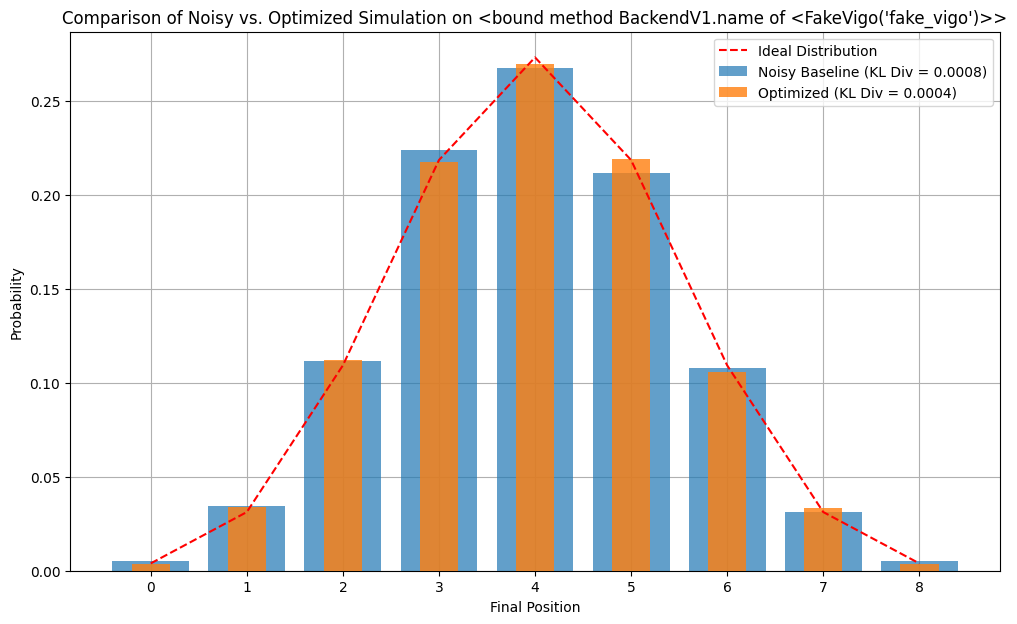

Noisy Baseline KL Divergence: 0.0008
Optimized KL Divergence: 0.0004


In [249]:
# 7. PLOT THE FINAL COMPARISON
# Create a bar chart comparing the ideal, baseline, and optimized distributions
plt.figure(figsize=(12, 7))
plt.bar(outcomes, probs_noisy, label=f'Noisy Baseline (KL Div = {kl_div_noisy:.4f})', zorder=2, alpha=0.7)
plt.bar(outcomes, probs_optimized, label=f'Optimized (KL Div = {kl_div_optimized:.4f})', zorder=3, alpha=0.8, width=0.4)
plt.plot(outcomes, ideal_probs, 'r--', label='Ideal Distribution', zorder=3)

# Add titles and labels for clarity
plt.title(f'Comparison of Noisy vs. Optimized Simulation on {backend.name}')
plt.xlabel('Final Position')
plt.ylabel('Probability')
plt.xticks(outcomes)
plt.legend()
plt.grid(True)
plt.show()

# Print the final metrics to explicitly show the improvement from optimization
print(f"Noisy Baseline KL Divergence: {kl_div_noisy:.4f}")
print(f"Optimized KL Divergence: {kl_div_optimized:.4f}")